# Wikipathways Yeast 2018

Author: Zachary Flamholz  
Date: 07-2018  
Database: https://www.wikipathways.org/    
Data: http://data.wikipathways.org/20180610/gpml/wikipathways-20180610-gpml-Saccharomyces_cerevisiae.zip (v. 20180610 (10 June 2018)      
Companion file: http://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Fungi/Saccharomyces_cerevisiae.gene_info.gz      

## import libraries

In [20]:
import numpy as np
import pandas as pd
import sys, datetime
import scipy.stats as stat
import matplotlib
from matplotlib import pyplot as py

# Versions of Modules in use

In [2]:
%load_ext version_information
%version_information numpy, pandas

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)]
IPython 6.4.0
OS Darwin 17.5.0 x86_64 i386 64bit
numpy 1.14.5
pandas 0.23.1
Mon Jul 09 17:54:08 2018 EDT

## read in data 

In [3]:
df = pd.read_csv('input/wikipathways_sCerevisiae_2018', sep = '~', header=None)

In [4]:
df.head()

,0
0,Glycine biosynthesis%WikiPathways_20180610%WP2...
1,Glucose-1-phosphate metabolism%WikiPathways_20...
2,De Novo Biosynthesis of Purine Nucleotides%Wik...
3,"RuMP cycle, containing ""Oxidative Branch of th..."
4,"Fatty Acid Elongation, Saturated%WikiPathways_..."


In [5]:
df.iloc[0]

0    Glycine biosynthesis%WikiPathways_20180610%WP2...
Name: 0, dtype: object

In [6]:
sCerevisiae_geneInfo = pd.read_csv("input/Saccharomyces_cerevisiae.gene_info", sep="\t")

## load NCBI reference for converting ENTREZ gene ID to gene symbol

In [7]:
sCerevisiae_geneInfo.head()

,#tax_id,GeneID,Symbol,LocusTag,Synonyms,dbXrefs,chromosome,map_location,description,type_of_gene,Symbol_from_nomenclature_authority,Full_name_from_nomenclature_authority,Nomenclature_status,Other_designations,Modification_date,Feature_type
0,4932,2828223,NEWENTRY,-,-,-,-,-,Record to support submission of GeneRIFs for a...,other,-,-,-,-,20180616,-
1,4932,24573110,atp6,ACI60_gp06,-,-,MT,-,Atp6,protein-coding,-,-,-,-,20180130,-
2,4932,24573111,ACI60_gt03,ACI60_gt03,-,-,MT,-,tRNA,tRNA,-,-,-,-,20150619,-
3,4932,24573112,ACI60_gt04,ACI60_gt04,-,-,MT,-,tRNA,tRNA,-,-,-,-,20150619,-
4,4932,24573113,ACI60_gr01,ACI60_gr01,-,-,MT,-,large subunit ribosomal RNA,rRNA,-,-,-,-,20150619,-


In [8]:
sCerevisiae_proteinCoding = sCerevisiae_geneInfo[sCerevisiae_geneInfo["type_of_gene"] == "protein-coding"]

In [9]:
type(sCerevisiae_geneInfo.iloc[0, 1])

numpy.int64

In [10]:
sCerevisiae_geneInfo.loc[sCerevisiae_geneInfo['GeneID'] == 850514]['Symbol'].iloc[0]

'AGX1'

## build a dictionary of terms and genes

In [11]:
pathway_dict = {}
for row in df.itertuples():
    splits = row[1].split('\t')
    term_split = splits[0].split('%')
    term = term_split[0] + '_' + term_split[2]
    pathway_dict[term] = []
    for i in range(2, len(splits)):
        if int(splits[i]) in np.asarray(sCerevisiae_geneInfo['GeneID']):
            pathway_dict[term].append(sCerevisiae_geneInfo.loc[sCerevisiae_geneInfo['GeneID'] == int(splits[i])]['Symbol'].iloc[0])

## numbers for the library

In [12]:
## number of terms
len(pathway_dict.keys())

112

In [21]:
dist = []
for i in list(pathway_dict.values()):
    dist.append(len(i))

(array([88., 13.,  5.,  3.,  0.,  0.,  1.,  0.,  1.,  1.]),
 array([  1.,  14.,  27.,  40.,  53.,  66.,  79.,  92., 105., 118., 131.]),
 <a list of 10 Patch objects>)

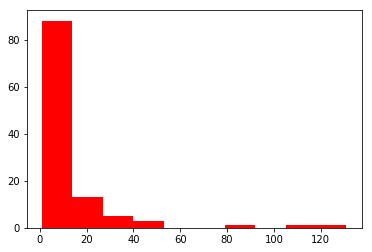

In [22]:
py.hist(dist, color='red')

In [13]:
pathway_dict['Glycine biosynthesis_WP261']

['AGX1', 'SHM2', 'SHM1', 'GLY1']

## build gmt

In [14]:
filename = 'wikipathways_greater4_%s.gmt'% str(datetime.date.today())[0:7].replace('-', '_')
file = open(filename,'w+') 
terms = pathway_dict.keys()
for i,term in enumerate(terms):
    
    progressPercent = ((i+1)/len(terms))*100
    sys.stdout.write("Progress: %d%%  %d Out of %d   \r" % (progressPercent, (i+1), len(terms)))
    sys.stdout.flush()
    
    if len(pathway_dict[term]) > 4:
        file.write("%s\t" % term)
        file.write("\t")
        genes = pathway_dict[term]
    
        for gene in genes:
              file.write("%s\t" % gene)
        file.write("\n")
        
file.close()

## get gmt stats

In [15]:
def getTermStats(loaded_gmt, geneInfoTable, num_samplings, num_genes_in_sampling) :
    # get the relevant terms and set a dictionary for them
    term_set = loaded_gmt.iloc[:,0].apply(lambda x: x.split("\t")[0])
    term_genes_dict = {term_set[i]: loaded_gmt.iloc[i,0].split("\t")[2:] for i in range(0, loaded_gmt.shape[0])}
    term_rank_dict = {k: [] for k in term_set}
    term_stats_dict = {k: [] for k in term_set}
    
    # get the total number of genes in the organism
    n_genes = len(geneInfoTable["Symbol"].unique())
    
    # number of genes per sampling, number of times to sample
    genes_in_sampleing = num_genes_in_sampling
    num_samplings = num_samplings
    
    for i,x in enumerate(range(0,num_samplings)):
        
        progressPercent = ((i+1)/len(range(0,num_samplings)))*100
        
        sys.stdout.write("Progress: %d%%  %d Out of %d   \r" % (progressPercent, (i+1), len(range(0,num_samplings))))
        sys.stdout.flush()
            
        
        randomSet = set(geneInfoTable["Symbol"].sample(genes_in_sampleing).apply(lambda x: x.split('.')[0]))
        
        # initialize an array to hold the pvalue for each term
        pvals = np.array([])
        for key in term_rank_dict.keys():
            
            termSet = set(term_genes_dict[key])
            # calculate p value using fisher exact test
            # implemented using the formula found in the GeneOverap bioconductor package for R
            pval_term = stat.fisher_exact([[n_genes - len(termSet.union(randomSet)), len(randomSet.difference(termSet))], [len(termSet.difference(randomSet)), len(termSet.intersection(randomSet))]])[1]
            pvals = np.append(pvals, [pval_term])
        
        # sort the pvals and add the rank to the term_rank dict
        sorted_pvals = pvals.argsort()
        
        # find the rank for each term by sorting the pvals array and getting the index of the key position in the
        # sorted list. Need to +1 because the index begins with 0
        
        for j,key in enumerate(term_rank_dict.keys()):
            term_rank_dict[key].append(np.where(sorted_pvals == j)[0][0] + 1)
            
    for key in term_rank_dict:
        term_stats_dict[key] = [np.mean(term_rank_dict[key]), np.std(term_rank_dict[key])]
            
    
    
    return term_stats_dict

In [16]:
## load gmt
wikipathway_gmt = pd.read_csv("wikipathways_greater4_2018_07.gmt", sep="~", header=None)

In [17]:
wikipathway_gmt.head()

,0
0,Glucose-1-phosphate metabolism_WP260\t\tGLC3\t...
1,De Novo Biosynthesis of Purine Nucleotides_WP2...
2,"RuMP cycle, containing ""Oxidative Branch of th..."
3,Pentose Phosphate Pathway_WP369\t\tTKL2\tGND2\...
4,"Fatty Acid Biosynthesis, Initial Steps_WP137\t..."


In [18]:
iterations_200 = getTermStats(wikipathway_gmt, sCerevisiae_proteinCoding, num_samplings=200, num_genes_in_sampling=300)

In [19]:
df_200_iterations = pd.DataFrame.from_dict(iterations_200, orient='index', columns = ['mean', 'sd'])
df_200_iterations.to_csv('output/wikipathways_greater4_2018_07_stats.tsv', sep='\t', header=False)